In [1]:
import sys
import os, tempfile
import os.path as osp

import numpy as np
from ipyfilechooser import FileChooser
from IPython.display import Markdown
import ipywidgets as widgets
from pathlib import Path
import xarray as xr
import ngff_zarr
import dask.diagnostics
from tqdm import tqdm
from glob import glob

from multiview_stitcher import (
    registration,
    fusion,
    msi_utils,
    io,
    mv_graph,
    vis_utils,
    msi_utils,
    ngff_utils,
    transformation,
    spatial_image_utils,
)

from napari_stitcher import (  # remove
    viewer_utils
)

def printmd(string):
    display(Markdown(string))

In [2]:
# browse file system to dataset folder
printmd("**Choose a folder containing only the files you want to register**")

fc = FileChooser()
fc.use_dir_icons = True
display(fc)

printmd("**Choose file format**")
format_wid = widgets.Text(value='.czi',placeholder='Type file format',description='File format:')
display(format_wid)

printmd("**Filter files**")
filter_wid = widgets.Text(value='',placeholder='Type in filter',description='Filter by:')
display(filter_wid)

**Choose a folder containing only the files you want to register**

FileChooser(path='/Users/amichaut/Desktop/nap-stitch', filename='', title='', show_hidden=False, select_desc='…

**Choose file format**

Text(value='.czi', description='File format:', placeholder='Type file format')

**Filter files**

Text(value='', description='Filter by:', placeholder='Type in filter')

In [3]:
# filter files
file_format = format_wid.value
file_filter = filter_wid.value

# get all full path of files in chosen folder
datadir = fc.selected_path  # chosen foder
file_list = os.listdir(datadir)  # list directory
path_list = [osp.join(datadir,fn) for fn in file_list]  # full path list
path_list = [fn for fn in path_list if not osp.isdir(fn)]  # keep only files
if len(file_format) > 0:
    path_list = [fn for fn in path_list if fn.endswith(file_format)]  # filter by file format
if len(file_filter) > 0:
    path_list = [fn for fn in path_list if file_filter in fn]  # filter by file format
path_list.sort()

printmd("**List of files (you can unselect them)**")
file_list_wid = widgets.SelectMultiple(options=path_list,value=path_list,description="File list",layout={'width': 'initial'})
display(file_list_wid)

printmd("**Output filename for concatenated movies or file ending for multiple files**")
out_fn_wid = widgets.Text(value='_stitched.tif',description='Filename:')
display(out_fn_wid)

**List of files (you can unselect them)**

SelectMultiple(description='File list', index=(0, 1), layout=Layout(width='initial'), options=('/Users/amichau…

**Output filename for concatenated movies or file ending for multiple files**

Text(value='_stitched.tif', description='Filename:')

## To batch register files independently

In [ ]:
reg_channel_index = 0

# process all files 
for i,fn in enumerate(file_list_wid.value): 
    print("processing {} ({}/{})".format(fn,i+1,len(file_list_wid.value)))

    msims = [msi_utils.get_msim_from_sim(sim, scale_factors=[])
             for sim in io.read_mosaic_image_into_list_of_spatial_xarrays(fn, scene_index=0)]

    # register data
    temp_dir = tempfile.TemporaryDirectory(dir=datadir)
    with dask.diagnostics.ProgressBar():

        params = registration.register(
            msims,
            transform_key=io.METADATA_TRANSFORM_KEY,
            new_transform_key='affine_registered',
            reg_channel_index=reg_channel_index,
            pre_registration_pruning_method='keep_axis_aligned',  # to get from user parameter 
            registration_binning={'y': 1, 'x': 1},  # to get from user parameter 
            post_registration_do_quality_filter=True,
            post_registration_quality_threshold=0.2,
        )

        fused_sim = fusion.fuse(
            [msi_utils.get_sim_from_msim(msim) for msim in msims],
            transform_key='affine_registered',
            #output_chunksize=256,
            )

        fused_ngff_multiscales = ngff_zarr.to_multiscales(
            ngff_utils.sim_to_ngff_image(
                fused_sim,
                transform_key='affine_registered'),
                scale_factors=[])

        output_filename = osp.join(temp_dir.name,'stitched.zarr')
        print(f'Fusing views and saving output to {output_filename}...')
        ngff_zarr.to_ngff_zarr(
            output_filename,
            fused_ngff_multiscales,
            )

        mfused = ngff_utils.ngff_multiscales_to_msim(
            ngff_zarr.from_ngff_zarr(output_filename),
            transform_key='affine_registered')

        output_stitched_fn = fn[:-4]+out_fn_wid.value
        print(f'Streaming into {output_stitched_fn}...')
        io.save_sim_as_tif(
            output_stitched_fn,
            msi_utils.get_sim_from_msim(mfused))

    # delete zarr files
    temp_dir.cleanup()

## To concatenate and register files together

In [4]:
reg_channel_index = 1

# output file
output_tif = osp.join(datadir,out_fn_wid.value)  # type in the output file
print("Output file: ",output_tif)
temp_dir = tempfile.TemporaryDirectory(dir=datadir)
output_filename = Path(osp.join(temp_dir.name,'concat'))

# concatenate files together
print("Concatenating: ",file_list_wid.value)

#### change here to fix a dataset-specific bug/ to return to the normal behavior, uncomment the next line and comment the following block
#simss = [io.read_mosaic_image_into_list_of_spatial_xarrays(filename, scene_index=0) for filename in file_list_wid.value]
### comment the block below to restore the normal behavior
simss = []
for filename in file_list_wid.value:
    sims = io.read_mosaic_image_into_list_of_spatial_xarrays(filename, scene_index=0)
    ## move tile tiles 2 and 3 up by 70 pixels
    #for itile in [2, 3]:
    #   sims[itile] = sims[itile].assign_coords(y= sims[itile].y.values + spatial_image_utils.get_spacing_from_sim(sims[itile])['y'] * 70)
    simss.append(sims)
 
# transform all input files so that they have the same stack properties (spacing, shape, origin) of the first file
simss = [[
    # transformation.transform_sim(
    fusion.fuse(
    [simss[iseq][itile]],
    transform_key=io.METADATA_TRANSFORM_KEY,
    output_stack_properties=spatial_image_utils.get_stack_properties_from_sim(simss[0][itile]))
        for itile in range(len(simss[0]))]
        for iseq in range(len(simss))]

sims = [xr.concat([simss[iseq][itile] for iseq in range(len(simss))], dim='t') for itile in range(len(simss[0]))]
sims = [sim.assign_coords({'t': range(len(sim.coords['t']))}) for sim in sims]

# # restrict time points for testing
# sims = [si_utils.sim_sel_coords(sim, {'t': slice(0, 3)}) for sim in sims]

# bin input
#sims = [sim.coarsen({'x': 2, 'y': 2}, boundary='trim').mean().astype(sim.data.dtype) for sim in sims]

#for itile in range(len(sims[:])):
#    sims[itile].attrs['transforms']['affine_metadata'] = \
#        xr.concat([sims[itile].attrs['transforms']['affine_metadata'][0]] * len(sims[0].coords['t']), dim='t')

print('Convert input into chunked zarr arrays...')
msims = [msi_utils.get_store_decorator(
    output_filename.with_suffix('.tile%03d.zarr' %isim), store_overwrite=True)(
        msi_utils.get_msim_from_sim)(sim, [])
    for isim, sim in tqdm(enumerate(sims), total=len(sims),colour="green",file=sys.stdout,)]

Output file:  /Users/amichaut/Desktop/temp/all_stitched.tif
Concatenating:  ('/Users/amichaut/Desktop/temp/10_stalling_e3_5X_max.czi', '/Users/amichaut/Desktop/temp/11_stalling_e3_5X_max.czi')


/var/folders/7m/w68wq4ns2qqfjzx4jtn4lt640000gn/T/ipykernel_88158/3295729759.py:17: DeprecationWarning: read_mosaic_image_into_list_of_spatial_xarrays is deprecated. Use read_mosaic_into_sims instead.
  sims = io.read_mosaic_image_into_list_of_spatial_xarrays(filename, scene_index=0)
/var/folders/7m/w68wq4ns2qqfjzx4jtn4lt640000gn/T/ipykernel_88158/3295729759.py:17: DeprecationWarning: read_mosaic_image_into_list_of_spatial_xarrays is deprecated. Use read_mosaic_into_sims instead.
  sims = io.read_mosaic_image_into_list_of_spatial_xarrays(filename, scene_index=0)


Convert input into chunked zarr arrays...
100%|█████████████████████████████████████████████| 9/9 [07:39<00:00, 51.06s/it]


In [5]:
# perform registration
# below you can change the registration binning

print('Registering...')
with dask.diagnostics.ProgressBar():
    params = registration.register(
        msims[:],
        transform_key='affine_metadata',
        new_transform_key='affine_registered',
        pre_registration_pruning_method='keep_axis_aligned',  # to get from user parameter 
        reg_channel_index=reg_channel_index,  # to get from user parameter 
        registration_binning={'y': 1, 'x': 1},  # to get from user parameter 
        )

for msim, param in zip(msims, params):
    msi_utils.set_affine_transform(msim, param, transform_key='affine_registered', base_transform_key='affine_metadata')

Registering...
[########################################] | 100% Completed | 3.60 ss
[########################################] | 100% Completed | 196.12 s


In [6]:
# perform the fusion

print('Creating fusion graph...')
with dask.diagnostics.ProgressBar():
    fused = fusion.fuse(
        [msi_utils.get_sim_from_msim(msim) for msim in msims],
        transform_key='affine_registered',
        output_chunksize=1024,
        )

print('Creating multiscale output OME-Zarr...')
with dask.diagnostics.ProgressBar():
    mfused = msi_utils.get_msim_from_sim(fused, scale_factors=[])
    mfused.to_zarr(output_filename)

mfused = msi_utils.multiscale_spatial_image_from_zarr(output_filename)

Creating fusion graph...
Creating multiscale output OME-Zarr...
[########################################] | 100% Completed | 323.11 s


In [7]:
# save fused output as tif file
print('Saving to tif...')
io.save_sim_as_tif(output_tif, mfused['scale0/image'])


Saving to tif...


100%|█████████████████████████████████████████| 306/306 [00:10<00:00, 28.69it/s]


In [18]:
# delete zarr files
temp_dir.cleanup()

In [4]:
# previous loading data cell


# # output file
# output_tif = osp.join(datadir,out_fn_wid.value)  # type in the output file
# print("Output file: ",output_tif)
# temp_dir = tempfile.TemporaryDirectory(dir=datadir)
# output_filename = Path(osp.join(temp_dir.name,'concat'))

# # concatenate files together
# print("Concatenating: ",file_list_wid.value)

# #### change here to fix a dataset-specific bug/ to return to the normal behavior, uncomment the next line and comment the following block
# #simss = [io.read_mosaic_image_into_list_of_spatial_xarrays(filename, scene_index=0) for filename in file_list_wid.value]
# ### comment the block below to restore the normal behavior
# simss = []
# for filename in file_list_wid.value:
#     sims = io.read_mosaic_image_into_list_of_spatial_xarrays(filename, scene_index=0)
#     # move tile tiles 2 and 3 up by 70 pixels
#     for itile in [2, 3]:
#        sims[itile] = sims[itile].assign_coords(y= sims[itile].y.values + spatial_image_utils.get_spacing_from_sim(sims[itile])['y'] * 70)
# simss.append(sims)
 
# # transform all input files so that they have the same stack properties (spacing, shape, origin) of the first file
# simss = [[transformation.transform_sim(
#     simss[iseq][itile],
#     output_stack_properties=spatial_image_utils.get_stack_properties_from_sim(simss[0][itile]),
#     keep_transform_keys=True)
#         for itile in range(len(simss[0]))]
#         for iseq in range(len(simss))]
 
# sims = [xr.concat([simss[iseq][itile] for iseq in range(len(simss))], dim='t') for itile in range(len(simss[0]))]
# sims = [sim.assign_coords({'t': range(len(sim.coords['t']))}) for sim in sims]

# # # restrict time points for testing
# # sims = [si_utils.sim_sel_coords(sim, {'t': slice(0, 3)}) for sim in sims]

# # bin input
# #sims = [sim.coarsen({'x': 2, 'y': 2}, boundary='trim').mean().astype(sim.data.dtype) for sim in sims]

# #for itile in range(len(sims[:])):
# #    sims[itile].attrs['transforms']['affine_metadata'] = \
# #        xr.concat([sims[itile].attrs['transforms']['affine_metadata'][0]] * len(sims[0].coords['t']), dim='t')

# print('Convert input into chunked zarr arrays...')
# msims = [msi_utils.get_store_decorator(
#     output_filename.with_suffix('.tile%03d.zarr' %isim), store_overwrite=True)(
#         msi_utils.get_msim_from_sim)(sim, [])
#     for isim, sim in tqdm(enumerate(sims), total=len(sims),colour="green",file=sys.stdout,)]

Output file:  /Users/amichaut/Desktop/20241108_no-epiboly/20X/new_e4_stitched.tif
Concatenating:  ('/Users/amichaut/Desktop/20241108_no-epiboly/20X/04_post-t1-20X_max-Scene-2-e4.czi', '/Users/amichaut/Desktop/20241108_no-epiboly/20X/05_post-t1-20X_max-Scene-2-e4.czi', '/Users/amichaut/Desktop/20241108_no-epiboly/20X/07_post-t2-20X_max-Scene-2-e4.czi')


RuntimeError: affine matrix has wrong number of rows

# Inspect quality and shifts of pairwise registrations

In [19]:
fn = file_list_wid.value[0]
#fn = "../image-datasets/arthur_20220621_premovie_dish2-max.czi"

sims = io.read_mosaic_image_into_list_of_spatial_xarrays(fn, scene_index=0)
msims = [msi_utils.get_msim_from_sim(sim, scale_factors=[]) for sim in sims]

reg_channel_index = 0
transform_key = io.METADATA_TRANSFORM_KEY
new_transform_key = "affine_registered"
pairs = None
registration_binning = None
use_only_overlap_region = True
pairwise_reg_func = registration.phase_correlation_registration
pre_registration_pruning_method = None

with dask.diagnostics.ProgressBar():
    msims_reg = [
        msi_utils.multiscale_sel_coords(
            msim, {"c": sims[imsim].coords["c"][reg_channel_index]})
        if "c" in msi_utils.get_dims(msim)
        else msim
        for imsim, msim in enumerate(msims)]

    g = mv_graph.build_view_adjacency_graph_from_msims(
        msims_reg,
        transform_key=transform_key,
        pairs=pairs,
    )

    if pre_registration_pruning_method is not None:
        g_reg = mv_graph.prune_view_adjacency_graph(
            g,
            method=pre_registration_pruning_method,
        )
    else:
        g_reg = g

    g_reg_computed = registration.compute_pairwise_registrations(
        msims_reg,
        g_reg,
        transform_key=transform_key,
        registration_binning=registration_binning,
        use_only_overlap_region=use_only_overlap_region,
        pairwise_reg_func=pairwise_reg_func,
        pairwise_reg_func_kwargs={},
    )


[########################################] | 100% Completed | 2.61 ss
[########################################] | 100% Completed | 45.60 ss


## Visualize quality at a given tp


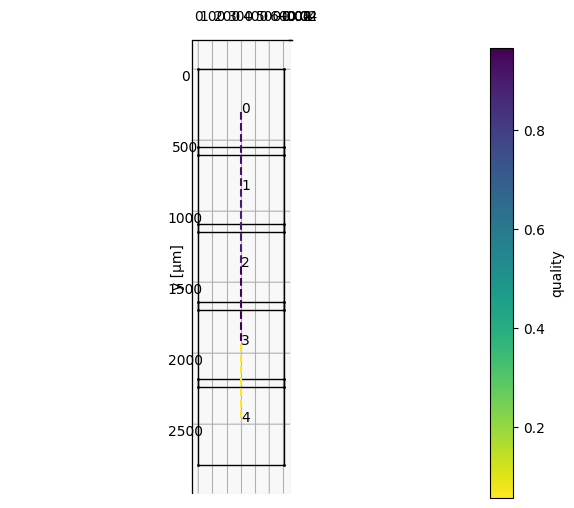

In [20]:
import networkx as nx
from matplotlib import colormaps as cm

edges_df = nx.to_pandas_edgelist(g_reg_computed)

tp_to_show = 10

edges = list(g_reg.edges())
edge_vals = np.array([g_reg_computed.get_edge_data(*e)['quality'][tp_to_show] for e in edges])
fig, ax = vis_utils.plot_positions(
    msims,
    transform_key=transform_key,
    edges=edges,
    edge_color_vals=edge_vals,
    edge_cmap=cm.get_cmap('viridis_r'),
    # edge_clims=[0,1],
    edge_label="quality",
    display_view_indices=True,
    use_positional_colors=False,
    )

## Visualize shift at a given tp

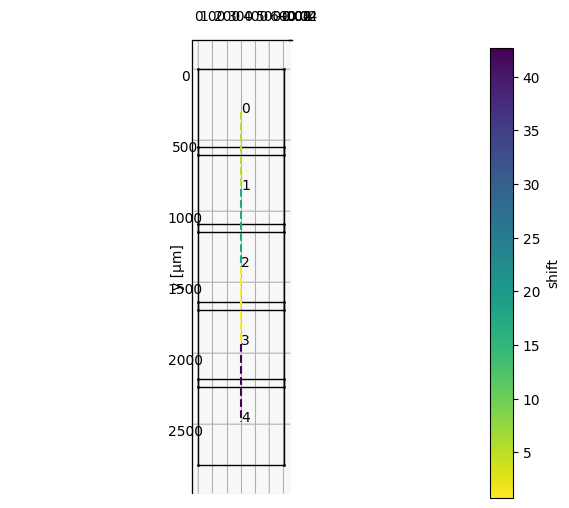

In [21]:
import networkx as nx
from matplotlib import colormaps as cm

edges_df = nx.to_pandas_edgelist(g_reg_computed)

tp_to_show = 10

edges = list(g_reg.edges())
# edge_vals = np.array([min(g_reg_computed.get_edge_data(*e)['quality']) for e in edges])
# edge_vals = np.array([g_reg_computed.get_edge_data(*e)['quality'][tp_to_show] for e in edges])
edge_vals = [np.mean(np.linalg.norm(es['transform'][:, :2, 2], axis=-1)) for ie, es in edges_df.iterrows()]
fig, ax = vis_utils.plot_positions(
    msims,
    transform_key=transform_key,
    edges=edges,
    edge_color_vals=edge_vals,
    edge_cmap=cm.get_cmap('viridis_r'),
    # edge_clims=[0,1],
    edge_label="shift",
    display_view_indices=True,
    use_positional_colors=False,
    )

## Visualize quality over time

Text(0, 0.5, 'Pairwise registration quality')

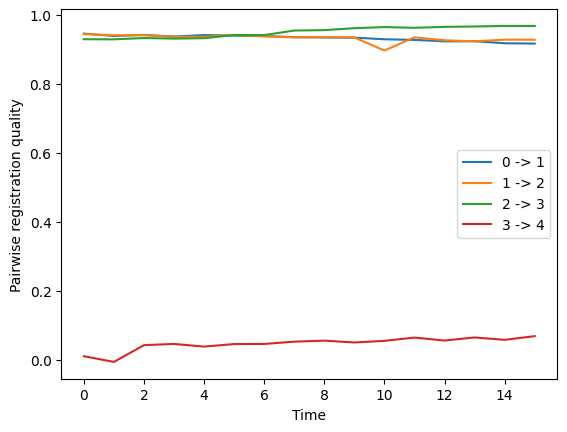

In [22]:
from matplotlib import pyplot as plt
edges_df = nx.to_pandas_edgelist(g_reg_computed)


plt.figure()
for ir, es in edges_df.iterrows():
    data = es['quality']
    plt.plot(data, label=f'{es["source"]} -> {es["target"]}')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Pairwise registration quality')

## Visualize shift over time

Text(0, 0.5, 'Registration shift [um]')

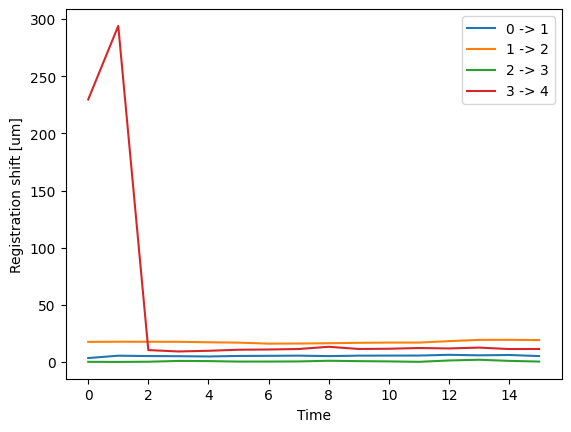

In [23]:

edges_df = nx.to_pandas_edgelist(g_reg_computed)

plt.figure()
for ir, es in edges_df.iterrows():
    timecourse = np.linalg.norm(es['transform'][:, :2, 2], axis=-1)
    plt.plot(timecourse, label=f'{es["source"]} -> {es["target"]}')
#     plt.plot(es['quality'], label=f'{es["source"]} -> {es["target"]}')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Registration shift [um]')

## Filter pairwise registrations by quality

(20240223: this needs to be checked improved)

In [116]:
post_registration_do_quality_filter = True
post_registration_quality_threshold = 0.3

if post_registration_do_quality_filter:
    # filter edges by quality
    g_reg_computed = mv_graph.filter_edges(
        g_reg_computed,
        threshold=post_registration_quality_threshold,
        weight_key="quality",
    )

params = registration.get_node_params_from_reg_graph(g_reg_computed)
params = [params[iview] for iview in sorted(g_reg_computed.nodes())]

if new_transform_key is not None:
    for imsim, msim in enumerate(msims):
        msi_utils.set_affine_transform(
            msim,
            params[imsim],
            transform_key=new_transform_key,
            base_transform_key=transform_key,
        )